/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


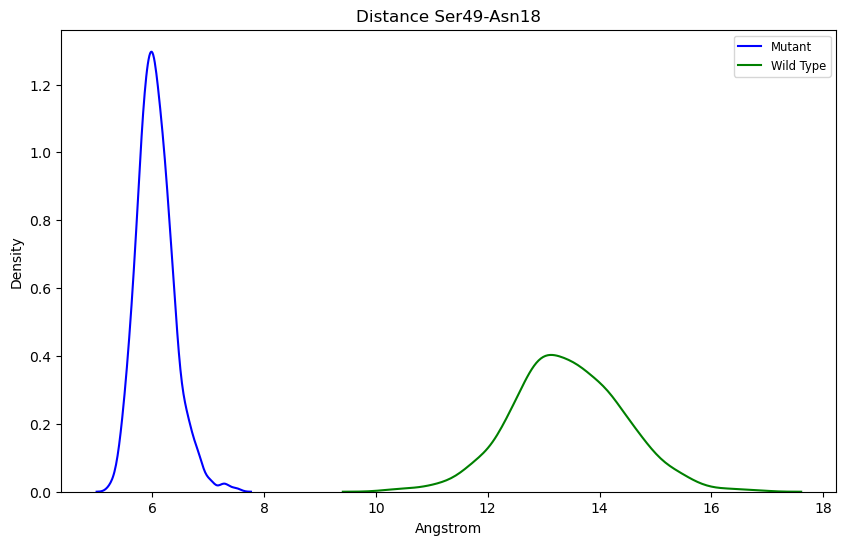

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to read .agr file and extract data from frame 1500 onwards
def read_agr_file(filename, start_frame=1500, end_frame=2600):
    frames = []
    values = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('@type xy'):
                break
        for line in file:
            if line.startswith('@'):
                continue
            parts = line.split()
            if len(parts) == 2:
                frame = int(float(parts[0]))
                value = float(parts[1])
                if frame >= start_frame and (end_frame is None or frame <= end_frame):
                    frames.append(frame)
                    values.append(value)
    return values

# List of colors for the KDE plots
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot multiple KDEs
def plot_kdes(filenames, legend_names):
    plt.figure(figsize=(10, 6))  # Set the figure size
    for idx, filename in enumerate(filenames):
        values = read_agr_file(filename)
        sns.kdeplot(values, color=colors[idx % len(colors)], label=legend_names[idx])

    # Add labels and title
    plt.xlabel('Angstrom')
    plt.ylabel('Density')
    plt.title('Distance Ser49-Asn18')
    

    # Add legend
    plt.legend(loc='upper right', fontsize='small')
    
    #plt.savefig("ser49_asn18_30ns.png", dpi=1200)

    # Display plot
    plt.show()

# List of specific .agr files to read
filenames = ['3ql0_dist_N18-S50_CA.agr','3ql3_dist_N18-S49_CA.agr'] 

# Custom legend names
legend_names = ['Mutant', 'Wild Type']

# Plot KDEs for the given files with custom legend names
plot_kdes(filenames, legend_names)

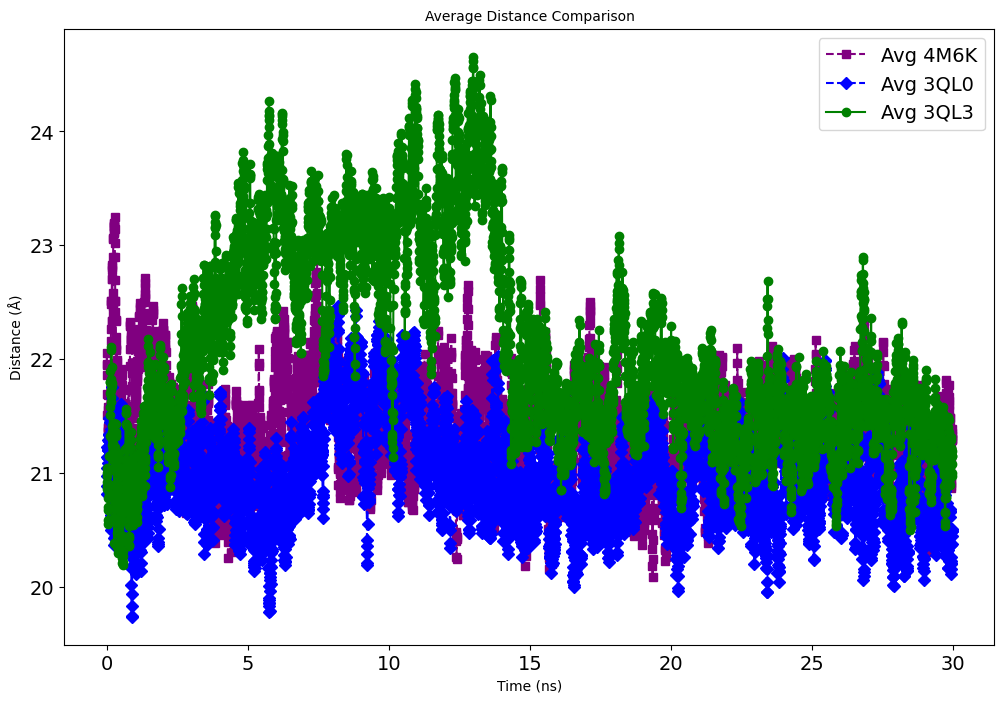

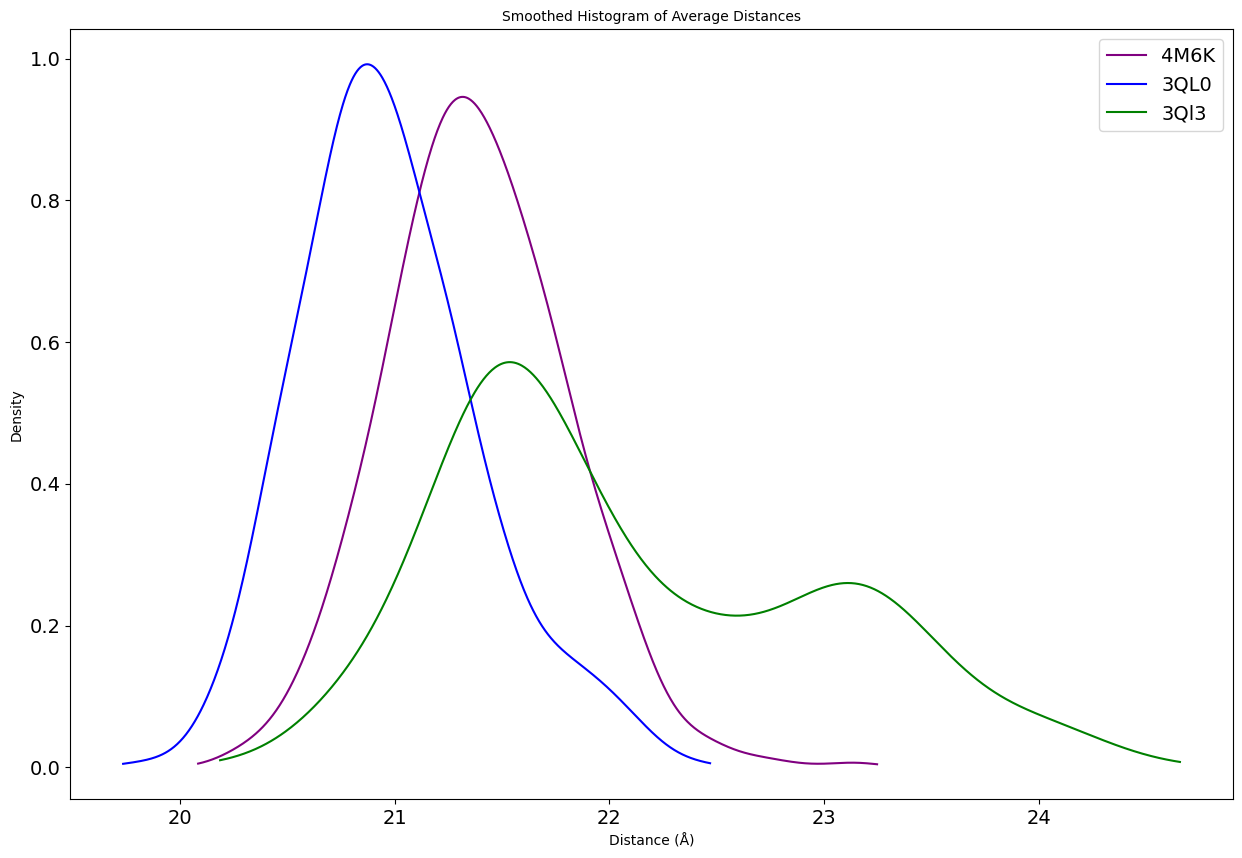

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Function to read .agr file and extract data
def read_agr_file(filename):
    frames = []
    values = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('@type xy'):
                break
        for line in file:
            if line.startswith('@'):
                continue
            parts = line.split()
            if len(parts) == 2:
                frames.append(float(parts[0]))
                values.append(float(parts[1]))
    return values

# Smoothing function
def smooth(data, window_size=5):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# List of WT and mutant .agr files to read (update with your filenames)
wt_filenames = ['3ql3_dist_W22-P53_CA.agr','3ql3_dist_N23-P53_CA.agr','3ql3_dist_L24-P53_CA.agr']
mut_filenames = ['3ql0_dist_W22-P54_CA.agr','3ql0_dist_P23-P54_CA.agr','3ql0_dist_L25-P54_CA.agr']
human_filenames = ['4m6k_dist_W24-P66_CA.agr','4m6k_dist_P25-P66_CA.agr','4m6k_dist_L27-P66_CA.agr']

# Read the data from the .agr files
wt_datasets = [read_agr_file(filename) for filename in wt_filenames]
mut_datasets = [read_agr_file(filename) for filename in mut_filenames]
human_datasets = [read_agr_file(filename) for filename in human_filenames]


smoothed_wt_datasets = [smooth(data[1:6000]) for data in wt_datasets]
smoothed_mut_datasets = [smooth(data[1:6000]) for data in mut_datasets]
smoothed_human_datasets = [smooth(data[1:6000]) for data in human_datasets]

# Ensure all datasets have the same length after smoothing
min_length_wt = min(len(data) for data in smoothed_wt_datasets)
min_length_mut = min(len(data) for data in smoothed_mut_datasets)
min_length_human = min(len(data) for data in smoothed_mut_datasets)
smoothed_wt_datasets = [data[:min_length_wt] for data in smoothed_wt_datasets]
smoothed_mut_datasets = [data[:min_length_mut] for data in smoothed_mut_datasets]
smoothed_human_datasets = [data[:min_length_human] for data in smoothed_human_datasets]

# Average the datasets frame-by-frame
avg_wt_data = np.mean(smoothed_wt_datasets, axis=0)
avg_mut_data = np.mean(smoothed_mut_datasets, axis=0)
avg_human_data = np.mean(smoothed_human_datasets, axis=0)

# Convert frame numbers to time (ns)
time_ns = np.arange(len(avg_wt_data)) / 200  # Assuming each frame corresponds to 1/200 ns

# Set the font size for labels and title
font_size = 10

# Plot the averaged WT, mutant, and human data trendlines
plt.figure(figsize=(12, 8))

plt.plot(time_ns, avg_human_data, marker='s', linestyle='--', color='purple', label='Avg 4M6K')
plt.plot(time_ns, avg_mut_data, marker='D', linestyle='--', color='blue', label='Avg 3QL0')
plt.plot(time_ns, avg_wt_data, marker='o', linestyle='-', color='green', label='Avg 3QL3')

# Add labels and title
plt.xlabel('Time (ns)', fontsize=font_size)
plt.ylabel('Distance (Å)', fontsize=font_size)
plt.title('Average Distance Comparison', fontsize=font_size)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("average_distance_1.png", dpi=1200)
plt.show()

# Compute histograms and smooth them using Gaussian KDE
def plot_smoothed_histogram(data, color, label):
    density = gaussian_kde(data)
    xs = np.linspace(min(data), max(data), 1000)
    density.covariance_factor = lambda: .25  # Smoothing parameter
    density._compute_covariance()
    plt.plot(xs, density(xs), color=color, label=label)

# Plot histograms with smoothed curves
plt.figure(figsize=(15, 10))

plot_smoothed_histogram(avg_human_data, color='purple', label='4M6K')
plot_smoothed_histogram(avg_mut_data, color='blue', label='3QL0')
plot_smoothed_histogram(avg_wt_data, color='green', label='3Ql3')


# Add labels and title
plt.xlabel('Distance (Å)', fontsize=font_size)
plt.ylabel('Density', fontsize=font_size)
plt.title('Smoothed Histogram of Average Distances', fontsize=font_size)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("smoothed_histogram_distance.png", dpi=1200)
plt.show()


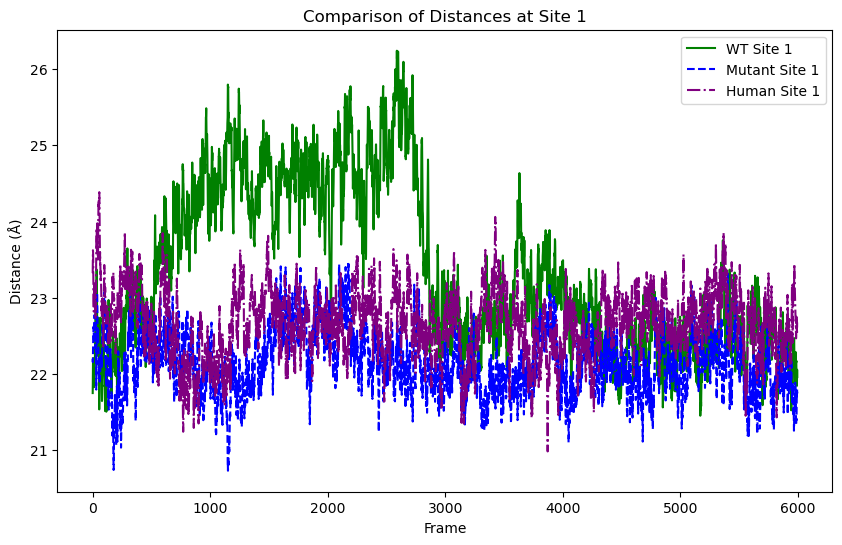

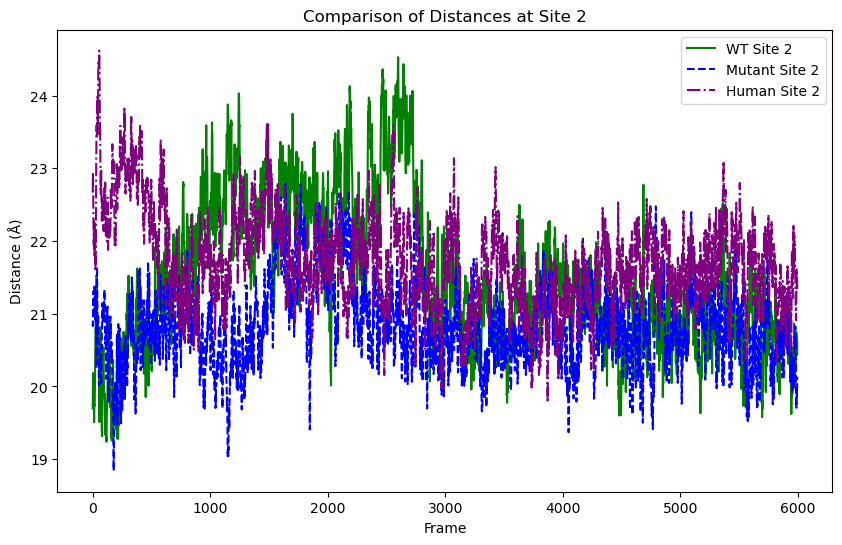

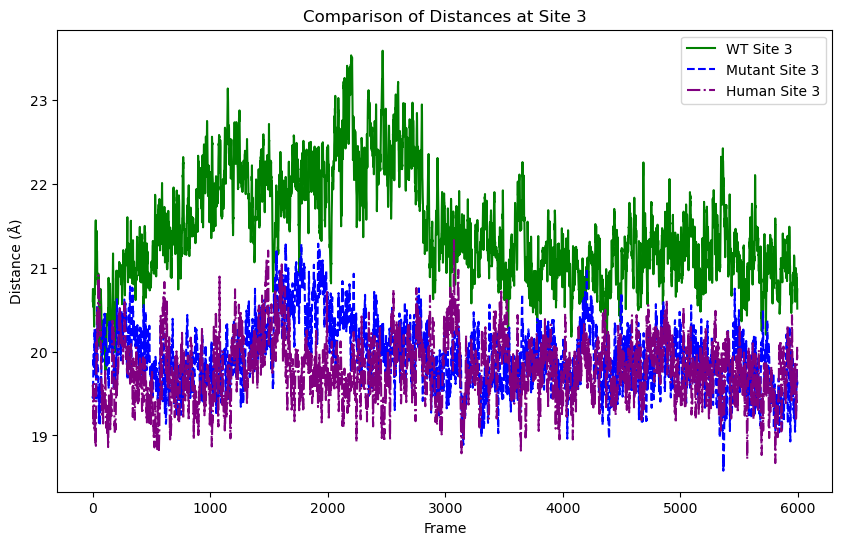

Site 1: WT Std: 1.080 Å, Mutant Std: 0.419 Å, Human Std: 0.441 Å
Site 2: WT Std: 1.011 Å, Mutant Std: 0.582 Å, Human Std: 0.645 Å
Site 3: WT Std: 0.635 Å, Mutant Std: 0.394 Å, Human Std: 0.373 Å


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levene
import pandas as pd
import seaborn as sns

# Function to read .agr file and extract data
def read_agr_file(filename):
    frames = []
    values = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('@type xy'):
                break
        for line in file:
            if line.startswith('@'):
                continue
            parts = line.split()
            if len(parts) == 2:
                frames.append(float(parts[0]))
                values.append(float(parts[1]))
    return values

# Smoothing function
def smooth(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# List of WT, mutant, and human .agr files to read
wt_filenames = ['3ql3_dist_W22-P53_CA.agr','3ql3_dist_N23-P53_CA.agr','3ql3_dist_L24-P53_CA.agr']
mut_filenames = ['3ql0_dist_W22-P54_CA.agr','3ql0_dist_P23-P54_CA.agr','3ql0_dist_L25-P54_CA.agr']
human_filenames = ['4m6k_dist_W24-P66_CA.agr','4m6k_dist_P25-P66_CA.agr','4m6k_dist_L27-P66_CA.agr']

# Read the data from the .agr files
wt_datasets = [read_agr_file(filename) for filename in wt_filenames]
mut_datasets = [read_agr_file(filename) for filename in mut_filenames]
human_datasets = [read_agr_file(filename) for filename in human_filenames]


smoothed_wt_datasets = [smooth(data[0:6000]) for data in wt_datasets]
smoothed_mut_datasets = [smooth(data[0:6000]) for data in mut_datasets]
smoothed_human_datasets = [smooth(data[0:6000]) for data in human_datasets]

# Ensure all datasets have the same length after smoothing
min_length_wt = min(len(data) for data in smoothed_wt_datasets)
min_length_mut = min(len(data) for data in smoothed_mut_datasets)
min_length_human = min(len(data) for data in smoothed_human_datasets)

# Find the minimum length across all three sets
min_length = min(min_length_wt, min_length_mut)#, min_length_human)

# Truncate datasets to the same length
smoothed_wt_datasets = [data[:min_length] for data in smoothed_wt_datasets]
smoothed_mut_datasets = [data[:min_length] for data in smoothed_mut_datasets]
smoothed_human_datasets = [data[:min_length] for data in smoothed_human_datasets]

# Plot the smoothed distances for each site
for i in range(3):
    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_wt_datasets[i], label=f'WT Site {i+1}', linestyle='-', color='green')
    plt.plot(smoothed_mut_datasets[i], label=f'Mutant Site {i+1}', linestyle='--', color='blue')
    plt.plot(smoothed_human_datasets[i], label=f'Human Site {i+1}', linestyle='-.', color='purple')
    plt.xlabel('Frame')
    plt.ylabel('Distance (Å)')
    plt.title(f'Comparison of Distances at Site {i+1}')
    plt.legend()
    #plt.savefig(f"distance_comparison_site_{i+1}.png", dpi=300)
    plt.show()

# Calculate and print the standard deviation for each site
for i in range(3):
    wt_std = np.std(smoothed_wt_datasets[i])
    mut_std = np.std(smoothed_mut_datasets[i])
    human_std = np.std(smoothed_human_datasets[i])
    print(f"Site {i+1}: WT Std: {wt_std:.3f} Å, Mutant Std: {mut_std:.3f} Å, Human Std: {human_std:.3f} Å")




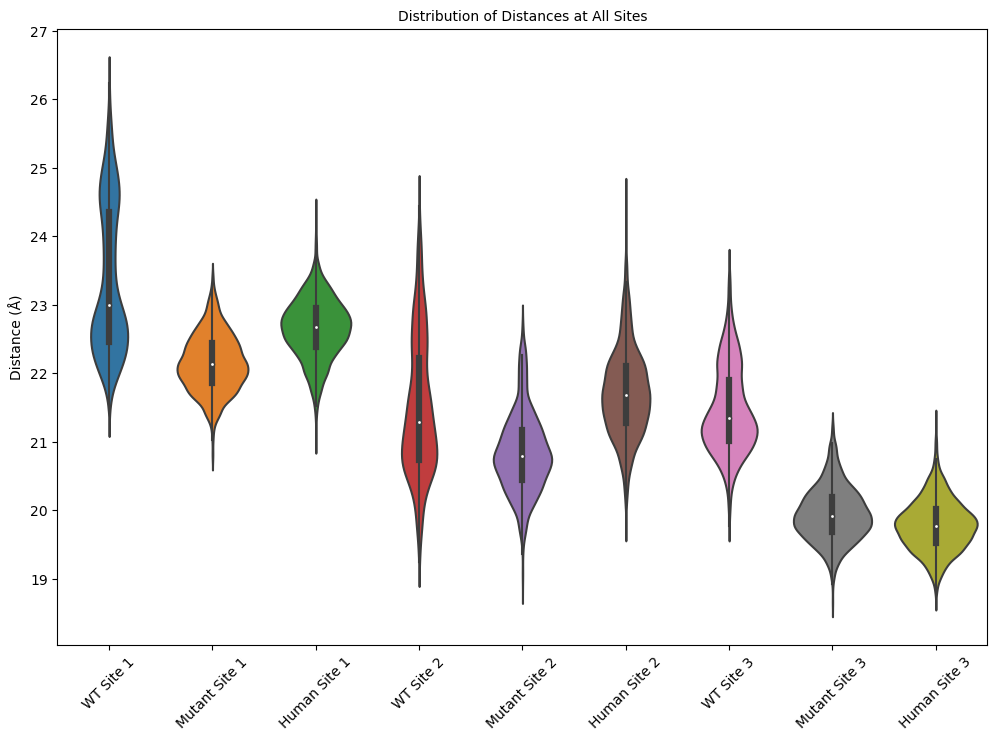

     Site       Comparison Levene Statistic       p-value
0  Site 1     WT vs Mutant  3865.1894148549  0.0000000000
1  Site 1      WT vs Human  3638.2657481627  0.0000000000
2  Site 1  Mutant vs Human     5.7137444057  0.0168479388
3  Site 2     WT vs Mutant  1490.7251336104  0.0000000000
4  Site 2      WT vs Human  1036.4277637203  0.0000000000
5  Site 2  Mutant vs Human    56.8771981104  0.0000000000
6  Site 3     WT vs Mutant  1044.0835619068  0.0000000000
7  Site 3      WT vs Human  1259.5457986033  0.0000000000
8  Site 3  Mutant vs Human    13.7465394401  0.0002101488


In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import levene
import pandas as pd

font_size = 10

# Violin plot to show the distribution of distances for each site
plt.figure(figsize=(12, 8))
all_data = [
    smoothed_wt_datasets[0], smoothed_mut_datasets[0], smoothed_human_datasets[0],
    smoothed_wt_datasets[1], smoothed_mut_datasets[1], smoothed_human_datasets[1],
    smoothed_wt_datasets[2], smoothed_mut_datasets[2], smoothed_human_datasets[2]
]
labels = ['WT Site 1', 'Mutant Site 1', 'Human Site 1', 'WT Site 2', 'Mutant Site 2', 'Human Site 2', 'WT Site 3', 'Mutant Site 3', 'Human Site 3']

sns.violinplot(data=all_data)
plt.xticks(np.arange(9), labels, rotation=45, fontsize=font_size)
plt.ylabel('Distance (Å)', fontsize=font_size)
plt.title('Distribution of Distances at All Sites', fontsize=font_size)
#plt.savefig("violin_plot_comparison.png", dpi=300)
plt.show()

# Initialize a dictionary to store the results for each comparison
levene_results = {
    'Site': [],
    'Comparison': [],
    'Levene Statistic': [],
    'p-value': []
}

# Perform pairwise Levene's test for each site
for i in range(3):
    wt_data = smoothed_wt_datasets[i]
    mut_data = smoothed_mut_datasets[i]
    human_data = smoothed_human_datasets[i]
    
    # Wild Type vs Mutant
    stat_wt_mut, p_value_wt_mut = levene(wt_data, mut_data)
    levene_results['Site'].append(f'Site {i+1}')
    levene_results['Comparison'].append('WT vs Mutant')
    levene_results['Levene Statistic'].append(f"{stat_wt_mut:.10f}")
    levene_results['p-value'].append(f"{p_value_wt_mut:.10f}")
    
    # Wild Type vs Human
    stat_wt_human, p_value_wt_human = levene(wt_data, human_data)
    levene_results['Site'].append(f'Site {i+1}')
    levene_results['Comparison'].append('WT vs Human')
    levene_results['Levene Statistic'].append(f"{stat_wt_human:.10f}")
    levene_results['p-value'].append(f"{p_value_wt_human:.10f}")
    
    # Mutant vs Human
    stat_mut_human, p_value_mut_human = levene(mut_data, human_data)
    levene_results['Site'].append(f'Site {i+1}')
    levene_results['Comparison'].append('Mutant vs Human')
    levene_results['Levene Statistic'].append(f"{stat_mut_human:.10f}")
    levene_results['p-value'].append(f"{p_value_mut_human:.10f}")

# Convert the results dictionary to a DataFrame
levene_df = pd.DataFrame(levene_results)

print(levene_df)

#levene_df.to_csv('levene_test_results.csv', index=False)


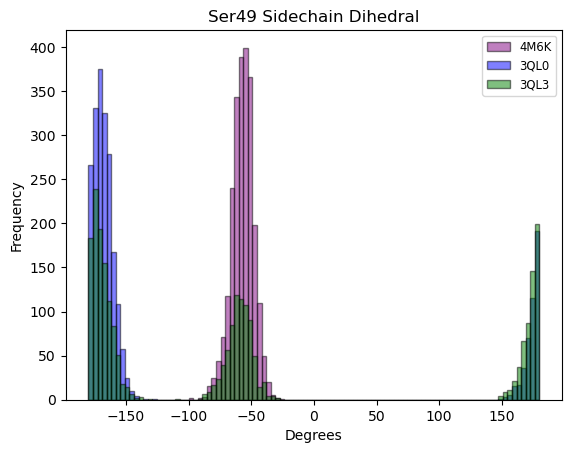

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Function to read .agr file and extract data from multiple frame ranges
def read_agr_file(filename, frame_ranges):
    frames = []
    values = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('@type xy'):
                break
        for line in file:
            if line.startswith('@'):
                continue
            parts = line.split()
            if len(parts) == 2:
                frame = int(float(parts[0]))
                value = float(parts[1])
                for start_frame, end_frame in frame_ranges:
                    if frame >= start_frame and (end_frame is None or frame <= end_frame):
                        frames.append(frame)
                        values.append(value)
                        break
    return values

# List of colors for the histograms
colors = ['purple','blue', 'green']

# Plot multiple histograms with customizable legend labels
def plot_histograms(filenames, frame_ranges, custom_labels=None):
    num_bins = np.linspace(-180, 180, 100)  
    if custom_labels is None:
        custom_labels = filenames  
    
    for idx, filename in enumerate(filenames):
        values = read_agr_file(filename, frame_ranges)
        label = custom_labels[idx] if idx < len(custom_labels) else filename
        plt.hist(values, bins=num_bins, edgecolor='black', color=colors[idx % len(colors)], alpha=0.5, label=label)

    # Add labels and title
    plt.xlabel('Degrees')
    plt.ylabel('Frequency')
    plt.title('Ser49 Sidechain Dihedral')

    # Add legend
    plt.legend(loc='upper right', fontsize='small')
    
    #plt.savefig("Ser49_dihedral_ec-h_2900-3400.png", dpi=1200)
    
    # Display plot
    plt.show()

# .agr files to read
filenames = ['dihedral_4m6k_S59chi_30ns.agr', 'dihedral_3ql0_ser50_30ns.agr','dihedral_3ql3_ser49_30ns.agr'] 

custom_labels=['4M6K','3QL0','3QL3'] 

#frame ranges to combine
frame_ranges = [(1000, 2900), (3500, 4000)]

plot_histograms(filenames, frame_ranges, custom_labels)